# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in Turi Create. You will:

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

Let's get started!


In [33]:
import pandas as pd
import numpy as np
import json
import sklearn
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier

# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

Let us start by loading the data.

In [4]:
loans = pd.read_csv("/Users/amitpatel/Desktop/ML_Washington/WashingtonML/Classification/Week4/lending-club-data.csv")

/Users/amitpatel/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [6]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
del loans['bad_loans']

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [7]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

We run the following code to do so:

In [12]:
len(features)

24

In [8]:
loans.shape

(122607, 68)

In [9]:
loans = loans[[target] + features].dropna() # drops the rows with at least one null values

In [10]:
loans.shape

(122578, 25)

In [11]:
loans.head()

,safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio,delinq_2yrs,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
0,1,B,0.4,0,11,RENT,27.65,credit_card,8.14350,0.0,...,0.0,1.0,83.7,0.00,10.65,861.07,24000.0,5000,4975,162.87
1,-1,C,0.8,1,1,RENT,1.00,car,2.39320,0.0,...,0.0,1.0,9.4,0.00,15.27,435.17,30000.0,2500,2500,59.83
2,1,C,1.0,0,11,RENT,8.72,small_business,8.25955,0.0,...,0.0,1.0,98.5,0.00,15.96,603.65,12252.0,2400,2400,84.33
3,1,C,0.2,0,11,RENT,20.00,other,8.27585,0.0,...,0.0,1.0,21.0,16.97,13.49,2209.33,49200.0,10000,10000,339.31
4,1,A,0.8,0,4,RENT,11.20,wedding,5.21533,0.0,...,0.0,1.0,28.3,0.00,7.90,631.38,36000.0,5000,5000,156.46


## One hot encoding

Then follow the following steps:

Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding.
Load the JSON files into the lists train_idx and test_idx.
Perform train/validation split using train_idx and test_idx. In Pandas, for instance:

In [19]:
loans = pd.get_dummies(loans, dummy_na = True) # dummy_na = True to keep the nan columns.

In [20]:
loans.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan
0,1,0.4,0,11,27.65,8.14350,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1.0,0,11,8.72,8.25955,0.0,1.0,2.0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0.2,0,11,20.00,8.27585,0.0,1.0,1.0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0.8,0,4,11.20,5.21533,0.0,1.0,3.0,1,...,0,0,0,0,0,0,0,0,1,0


## Test-Train Split

In [21]:
!ls

6-atp-I4EemJfgqR2HI2sA_0105449ffece4463b8b0c369c77de429_CLA08-NB01.ipynb.zip
CLA08-NB01.ipynb
Week5_boosting_assignment_1.ipynb
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-8-assignment-1-train-idx.json.zip
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-8-assignment-1-validation-idx.json.zip
boosting-annotated.pdf
module-8-assignment-1-train-idx.json
module-8-assignment-1-validation-idx.json


In [23]:
# Read the index for the train data
with open('module-8-assignment-1-train-idx.json', 'r') as filehandle:
    train_index = json.load(filehandle)

In [24]:
train_data = loans.iloc[train_index]

In [25]:
train_data.shape

(37219, 48)

In [26]:
# Read the index for the train data
with open('module-8-assignment-1-validation-idx.json', 'r') as filehandle:
    validation_index = json.load(filehandle)

In [98]:
validation_data = loans.iloc[validation_index]

In [99]:
validation_data.shape

(9284, 48)

# Gradient boosted tree classifier

Now, let's use the built-in scikit learn gradient boosting classifier (sklearn.ensemble.GradientBoostingClassifier) to create a gradient boosted classifier on the training data. You will need to import sklearn, sklearn.ensemble, and numpy.

You will have to first convert the SFrame into a numpy data matrix. See the API for more information. You will also have to extract the label column. Make sure to set max_depth=6 and n_estimators=5.

In [35]:
model_5 = GradientBoostingClassifier(max_depth = 6, n_estimators = 5)

In [36]:
# Taking the columns of the dataframe after the hot-one encoding
new_features = loans.drop('safe_loans',1).columns

In [38]:
model_5 = model_5.fit(train_data[new_features], train_data['safe_loans'])

In [39]:
model_5

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=5,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [40]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0


### Predicting on sample validation data

For each row in the **sample_validation_data**, write code to make **model_5** predict whether or not the loan is classified as a **safe loan**.

**Hint:** Use the `predict` method in `model_5` for this.

In [41]:
sample_predictions = model_5.predict(sample_validation_data[new_features])

In [42]:
sample_predictions

array([ 1,  1, -1,  1])

In [43]:
sample_validation_data['safe_loans']

22    1
26    1
24   -1
41   -1
Name: safe_loans, dtype: int64

In [46]:
percentage = sum(sample_predictions == np.array(sample_validation_data['safe_loans']))/len(sample_predictions)

In [47]:
percentage

0.75

**Quiz Question:** What percentage of the predictions on `sample_validation_data` did `model_5` get correct?

### Prediction probabilities

For each row in the sample_validation_data, what is the probability (according model_5) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

** Quiz Question: Which loan has the highest probability of being classified as a safe loan?**

**Checkpoint:** Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?

In [48]:
sample_proba = model_5.predict_proba(sample_validation_data[new_features])

In [49]:
sample_proba

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

** To identify the cofrresponding classes of the output of the above (n_samples, n_classes)**

In [50]:
model_5.classes_

array([-1,  1])

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

**Hint**:if you are using scikit-learn, you can use the .score() method

In [51]:
predictions_validation = model_5.predict(validation_data[new_features])

In [53]:
len(predictions_validation)

9284

In [54]:
accuracy_validation = sum(predictions_validation == np.array(validation_data['safe_loans']))/len(predictions_validation)

In [55]:
print("The accuracy on the validation data = ", accuracy_validation)

The accuracy on the validation data =  0.6614605773373546


Calculate the number of **false positives** made by the model.

In [115]:
model_5.score(validation_data[new_features], validation_data['safe_loans'])

0.6614605773373546

In [56]:
false_positives_count = sum( (predictions_validation == +1) &
                           (np.array(validation_data[target]) == -1))

**Quiz Question**: What is the number of **false positives** on the **validation_data**?

In [57]:
false_positives_count

1652

Calculate the number of **false negatives** made by the model.

In [58]:
false_negatives_count = sum( (predictions_validation == -1) &
                           (np.array(validation_data[target]) == +1))

In [59]:
false_negatives_count

1491

## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.

**Quiz Question**: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**?

In [60]:
cost = (20000*false_positives_count) + (10000*false_negatives_count)

In [61]:
cost

47950000

With single decision tree modle the total cost was = 50370000

In [64]:
diff = 50370000 - 47950000

In [65]:
diff

2420000

**Reminder**: Compare the cost of the mistakes made by the boosted trees model with the decision tree model. The extra 3% improvement in prediction accuracy can translate to several million dollars!  And, it was so easy to get by simply boosting our decision trees.

## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. Use `output_type = probability`.

In [66]:
validation_proba = model_5.predict_proba(validation_data[new_features])

In [69]:
len(validation_data)

9284

In [78]:
validation_proba

array([[0.53807792, 0.46192208],
       [0.39591639, 0.60408361],
       [0.52012758, 0.47987242],
       ...,
       [0.53530977, 0.46469023],
       [0.52280925, 0.47719075],
       [0.53807792, 0.46192208]])

In [85]:
validation_proba[:,1]

array([0.46192208, 0.60408361, 0.47987242, ..., 0.46469023, 0.47719075,
       0.46192208])

In [103]:
validation_data['predictions_proba'] = validation_proba[:,1]

/Users/amitpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
validation_data.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,predictions_proba
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,1,0,0,0,0,0.461922
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.604084
60,-1,0.4,0,5,12.48,3.57024,0.0,1.0,3.0,1,...,0,0,0,0,0,1,0,0,0,0.479872
93,-1,0.4,0,11,23.18,14.70090,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.406924
132,-1,0.2,0,3,7.83,11.04860,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,0,0,0.547199


**Quiz Question**: What grades are the top 5 loans?

Let us repeat this excercise to find the top 5 loans (in the **validation_data**) with the **lowest probability** of being predicted as a **safe loan**:

In [107]:
validation_data[['grade_A','grade_B','grade_C','grade_D','predictions_proba']].sort_values('predictions_proba', ascending = False).head(5)

,grade_A,grade_B,grade_C,grade_D,predictions_proba
8021,1,0,0,0,0.673059
92079,1,0,0,0,0.661468
68973,1,0,0,0,0.661468
19865,1,0,0,0,0.661468
19954,1,0,0,0,0.661468


In [108]:
validation_data[['grade_A','grade_B','grade_C','grade_D','predictions_proba']].sort_values('predictions_proba', ascending = True).head(5)

,grade_A,grade_B,grade_C,grade_D,predictions_proba
58794,0,0,1,0,0.307334
84508,0,0,1,0,0.307334
27502,0,0,1,0,0.312806
101746,0,0,0,1,0.315973
84921,0,0,1,0,0.315973


**Checkpoint:** You should expect to see 5 loans with the grade ['**D**', '**C**', '**C**', '**C**', '**B**'] or with ['**D**', '**C**', '**B**', '**C**', '**C**'].

## Effect of adding more trees

Train models with 10, 50, 100, 200, and 500 trees. Use the n_estimators parameter to control the number of trees. Remember to keep max_depth = 6.

Call these models model_10, model_50, model_100, model_200, and model_500, respectively. This may take a few minutes to run.

In [109]:
# Instantiate the modle
model_10 = GradientBoostingClassifier(max_depth = 6, n_estimators = 10)
# Train the model
model_10 = model_10.fit(train_data[new_features], train_data['safe_loans'])

In [110]:
# Instantiate the modle
model_50 = GradientBoostingClassifier(max_depth = 6, n_estimators = 50)
# Train the model
model_50 = model_50.fit(train_data[new_features], train_data['safe_loans'])

In [111]:
# Instantiate the modle
model_100 = GradientBoostingClassifier(max_depth = 6, n_estimators = 100)
# Train the model
model_100 = model_100.fit(train_data[new_features], train_data['safe_loans'])

In [113]:
# Instantiate the modle
model_200 = GradientBoostingClassifier(max_depth = 6, n_estimators = 200)
# Train the model
model_200 = model_200.fit(train_data[new_features], train_data['safe_loans'])

In [114]:
# Instantiate the modle
model_500 = GradientBoostingClassifier(max_depth = 6, n_estimators = 500)
# Train the model
model_500 = model_500.fit(train_data[new_features], train_data['safe_loans'])

## Compare accuracy on entire validation set
Now we will compare the predicitve accuracy of our models on the validation set.

Evaluate the accuracy of the 10, 50, 100, 200, and 500 tree models on the validation_data.

** Quiz Question:** Which model has the best accuracy on the validation_data?

** Quiz Question: ** Is it always true that the model with the most trees will perform best on test data?

In [116]:
accuracy_10 = model_10.score(validation_data[new_features], validation_data['safe_loans'])
accuracy_50 = model_50.score(validation_data[new_features], validation_data['safe_loans'])
accuracy_100 = model_100.score(validation_data[new_features], validation_data['safe_loans'])
accuracy_200 = model_200.score(validation_data[new_features], validation_data['safe_loans'])
accuracy_500 = model_500.score(validation_data[new_features], validation_data['safe_loans'])

In [117]:
print("Accuracy for model_10 = ", accuracy_10)
print("Accuracy for model_50 = ", accuracy_50)
print("Accuracy for model_100 = ", accuracy_100)
print("Accuracy for model_200 = ", accuracy_200)
print("Accuracy for model_500 = ", accuracy_500)

Accuracy for model_10 =  0.6663076260232659
Accuracy for model_50 =  0.68537268418785
Accuracy for model_100 =  0.6898965962947006
Accuracy for model_200 =  0.6896811719086601
Accuracy for model_500 =  0.6895734597156398


**Quiz Question:** Which model has the **best** accuracy on the **validation_data**?

**Quiz Question:** Is it always true that the model with the most trees will perform best on test data?

## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need [matplotlib](http://matplotlib.org/downloads.html) in order to visualize the plots. 

First, make sure this block of code runs on your computer.

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [124]:
train_err_10 = 1 - model_10.score(train_data[new_features], train_data['safe_loans'])
train_err_50 = 1 - model_50.score(train_data[new_features], train_data['safe_loans'])
train_err_100 = 1 - model_100.score(train_data[new_features], train_data['safe_loans'])
train_err_200 = 1 - model_200.score(train_data[new_features], train_data['safe_loans'])
train_err_500 = 1 - model_500.score(train_data[new_features], train_data['safe_loans'])

In [125]:
training_errors = [train_err_10,train_err_50,train_err_100,train_err_200,train_err_500]

In [126]:
validation_err_10 = 1 - model_10.score(validation_data[new_features], validation_data['safe_loans'])
validation_err_50 = 1 - model_50.score(validation_data[new_features], validation_data['safe_loans'])
validation_err_100 = 1 - model_100.score(validation_data[new_features], validation_data['safe_loans'])
validation_err_200 = 1 - model_200.score(validation_data[new_features], validation_data['safe_loans'])
validation_err_500 = 1 - model_500.score(validation_data[new_features], validation_data['safe_loans'])

In [127]:
validation_errors = [validation_err_10,validation_err_50,validation_err_100,validation_err_200,validation_err_500]

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

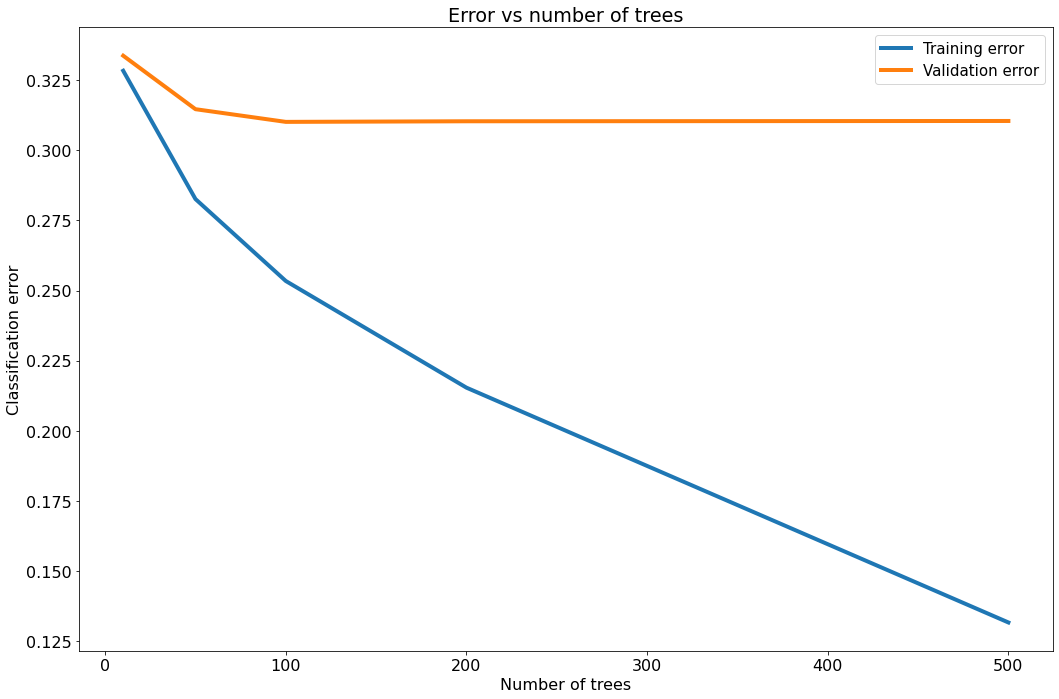

In [130]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(20,10), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

**Quiz Question**: Does the training error reduce as the number of trees increases?

**Quiz Question**: Is it always true that the validation error will reduce as the number of trees increases?

Quiz

In [132]:
0.5 * np.log((1-0.25)/0.25)

0.5493061443340549